In [1]:
###############################
#
#       Preprocessing
#
###############################

from bs4 import BeautifulSoup
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS
import re

def remove_punctuations(text):
    # Remove periods and commas
    text = text.replace('.', '').replace(',', '')
    # Replace hyphens with spaces
    text = text.replace('-', ' ')
    # Remove odd characters
    text = re.sub(r'[^a-zA-Z0-9\s\'#()\[\]\$]', '', text)
    return text

def remove_stopwords(text):
    # Convert text to lowercase
    #text_lower = text.lower()
    
    # Tokenize text into words
    words = text.split()
    
    # Remove stopwords if their lowercase matches stopword
    filtered_words = [word for word in words if word.lower() not in STOPWORDS]
    
    # Join filtered words back into a single string and return
    return ' '.join(filtered_words)

def remove_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def make_lowercase(text):
    return text.lower()

In [2]:
###############################
#
#          Question 1
#
###############################

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Load the data from CSV file
data = pd.read_csv('MLforEcon_W2024_pc6_data_without_response_v1.csv', header=None)

# Apply preprocessing to the text
data['text'] = data[0].apply(remove_html)
data['text'] = data['text'].apply(make_lowercase)
data['text'] = data['text'].apply(remove_stopwords)
data['text'] = data['text'].apply(remove_punctuations)

# Label the data based on the presence of "econom" in the text
data['label'] = data['text'].str.contains('econom', case=False).astype(int)
#data['label'] = data['text'].str.contains(r'(econom|stock)', case=False).astype(int)
print(data['label'].sum())

# Split the data into features (X) and labels (y)
X = data['text']
y = data['label']

# Vectorize the text data using TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X)

# Train a logistic regression model
model = LogisticRegression()

# Adjusting the class probability threshold to balance the predictions
model.fit(X_vectorized, y)
y_proba = model.predict_proba(X_vectorized)[:, 1]  # Probability of class 1
threshold = sorted(y_proba)[7789]  # Set threshold to ensure exactly half are 1s
#threshold = 0.5
predictions = (y_proba >= threshold).astype(int)
print(predictions.sum())

# Save predictions to a CSV file
pd.DataFrame({'prediction': predictions}).to_csv('preds.csv', index=False, header=False)

/var/folders/vm/wssbx9s12zn0bb8ys7m6r07c0000gn/T/ipykernel_45485/2692249493.py:38: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
/var/folders/vm/wssbx9s12zn0bb8ys7m6r07c0000gn/T/ipykernel_45485/604175643.py:22: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  data['label'] = data['text'].str.contains(r'(econom|stock)', case=False).astype(int)


8193
7792


In [3]:
original_text = pd.read_csv('MLforEcon_W2024_pc6_data_without_response_v1.csv', header=None, names=['text'])

num_lines_with_econom = original_text['text'].str.contains('econom', case=False).sum()
print(f"Number of text lines with 'econom' in it: {num_lines_with_econom}")

preds = pd.read_csv('preds.csv', header=None, names=['prediction'])

merged_data = pd.concat([original_text, preds], axis=1)

# Filter the rows where "econom" is present in the original text snippets
econom_present = merged_data[merged_data['text'].str.contains('econom', case=False)]

# Get line numbers where lines with "econom" present are not predicted as 1
incorrect_predictions = econom_present[econom_present['prediction'] != 1].index.tolist()
missed = econom_present[econom_present['prediction'] != 1]

# Print the line numbers
if not incorrect_predictions:
    print("All lines with 'econom' present are predicted as 1.")
else:
    print("Lines with 'econom' present not predicted as 1 are:")
    print(incorrect_predictions)
    for index, row in missed.iterrows():
        print(row['text'])

Number of text lines with 'econom' in it: 5266
Lines with 'econom' present not predicted as 1 are:
[24, 53, 99, 282, 288, 584, 612, 614, 641, 648, 652, 664, 676, 680, 739, 907, 911, 977, 985, 1132, 1153, 1183, 1204, 1223, 1373, 1474, 1492, 1558, 1634, 1645, 1660, 1785, 1845, 1885, 1973, 2077, 2119, 2141, 2177, 2179, 2186, 2192, 2334, 2347, 2374, 2393, 2426, 2519, 2532, 2617, 2618, 2659, 2753, 2795, 2814, 2827, 2859, 2937, 2943, 2991, 3015, 3018, 3050, 3068, 3130, 3139, 3238, 3244, 3256, 3297, 3299, 3409, 3504, 3513, 3546, 3642, 3777, 3805, 3846, 3872, 3900, 3942, 3946, 4003, 4012, 4081, 4137, 4140, 4167, 4173, 4228, 4332, 4384, 4391, 4393, 4398, 4415, 4510, 4526, 4562, 4676, 4706, 4732, 4737, 4743, 4767, 4799, 4841, 4893, 4962, 4972, 5065, 5101, 5134, 5208, 5218, 5228, 5239, 5256, 5367, 5532, 5605, 5652, 5712, 5788, 5896, 5927, 5949, 5954, 5980, 6019, 6021, 6067, 6121, 6160, 6327, 6366, 6371, 6379, 6451, 6522, 6626, 6668, 6734, 6753, 6765, 6827, 6885, 6945, 6977, 7031, 7147, 7251, 7287

In [3]:
# Read the output file final_preds.csv
output_df = pd.read_csv('preds.csv', header=None, names=['prediction'])

# Count the number of 1s and 0s
num_ones = (output_df['prediction'] == 1).sum()
num_zeros = (output_df['prediction'] == 0).sum()

# Print out the counts
print(f"Number of 1s: {num_ones}")
print(f"Number of 0s: {num_zeros}")

Number of 1s: 4584
Number of 0s: 10994


/var/folders/vm/wssbx9s12zn0bb8ys7m6r07c0000gn/T/ipykernel_20357/903999154.py:28: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


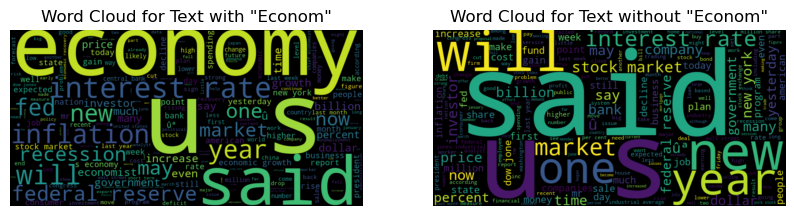

In [7]:
###############################
#
#         Question 2
#
###############################

from wordcloud import WordCloud
from wordcloud import STOPWORDS

# Load your data, adjust the file path or method based on your actual data
data = pd.read_csv('MLforEcon_W2024_pc6_data_without_response_v1.csv', header=None)

# Add a column 'text' to your DataFrame
data['text'] = data[0].apply(remove_html)
data['text'] = data['text'].apply(make_lowercase)
data['text'] = data['text'].apply(remove_stopwords)

# Separate the text snippets into two groups: with and without "econom"
econom_snippets = data[data['text'].str.contains('econom', case=False)]
other_snippets = data[~data['text'].str.contains('econom', case=False)]

# Generate word cloud for text snippets with "econom"
econom_text = ' '.join(econom_snippets['text'])
wordcloud_econom = WordCloud(width=800, height=400, background_color='black').generate(econom_text)

# Generate word cloud for text snippets without "econom"
other_text = ' '.join(other_snippets['text'])
wordcloud_other = WordCloud(width=800, height=400, background_color='black').generate(other_text)

# Plot the word clouds
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_econom, interpolation='bilinear')
plt.title('Word Cloud for Text with "Econom"')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_other, interpolation='bilinear')
plt.title('Word Cloud for Text without "Econom"')
plt.axis('off')

plt.show()

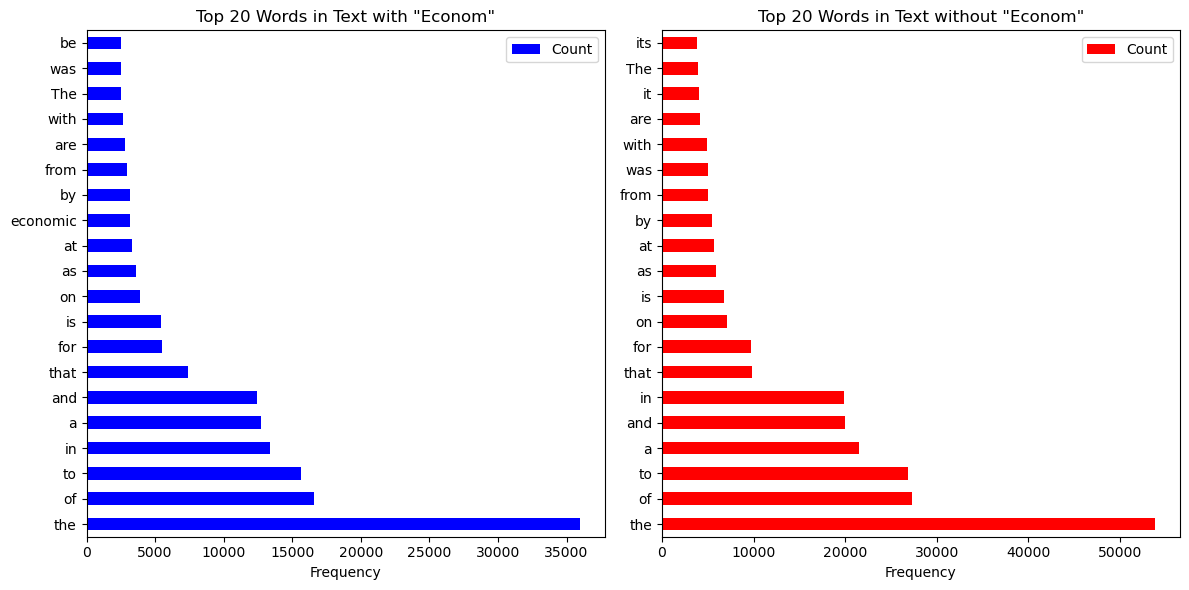

In [1]:
###############################
#
#         Question 3
#
###############################

from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# Load your data, adjust the file path or method based on your actual data
data = pd.read_csv('MLforEcon_W2024_pc6_data_without_response_v1.csv', header=None)

# Add a column 'text' to your DataFrame
data['text'] = data[0].apply(remove_html)
data['text'] = data['text'].apply(make_lowercase)
data['text'] = data['text'].apply(remove_stopwords)

# Separate the text snippets into two groups: with and without "econom"
econom_snippets = data[data['text'].str.contains('econom', case=False)]
other_snippets = data[~data['text'].str.contains('econom', case=False)]

# Function to calculate word frequencies
def calculate_word_frequencies(text_list):
    word_counts = Counter()
    for text in text_list:
        words = text.split()
        word_counts.update(words)
    return word_counts

# Calculate word frequencies for snippets with "econom"
econom_word_freq = calculate_word_frequencies(econom_snippets['text'])

# Calculate word frequencies for snippets without "econom"
other_word_freq = calculate_word_frequencies(other_snippets['text'])

# Convert word frequencies to DataFrames for easier manipulation
econom_word_freq_df = pd.DataFrame.from_dict(econom_word_freq, orient='index', columns=['Count'])
other_word_freq_df = pd.DataFrame.from_dict(other_word_freq, orient='index', columns=['Count'])

# Sort the DataFrames by word frequency
econom_word_freq_df = econom_word_freq_df.sort_values(by='Count', ascending=False)
other_word_freq_df = other_word_freq_df.sort_values(by='Count', ascending=False)

# Plot the word frequencies for each group
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
econom_word_freq_df.head(20).plot(kind='barh', color='blue', ax=plt.gca())
plt.title('Top 20 Words in Text with "Econom"')
plt.xlabel('Frequency')

plt.subplot(1, 2, 2)
other_word_freq_df.head(20).plot(kind='barh', color='red', ax=plt.gca())
plt.title('Top 20 Words in Text without "Econom"')
plt.xlabel('Frequency')

plt.tight_layout()
plt.show()

/var/folders/vm/wssbx9s12zn0bb8ys7m6r07c0000gn/T/ipykernel_46801/2692249493.py:38: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


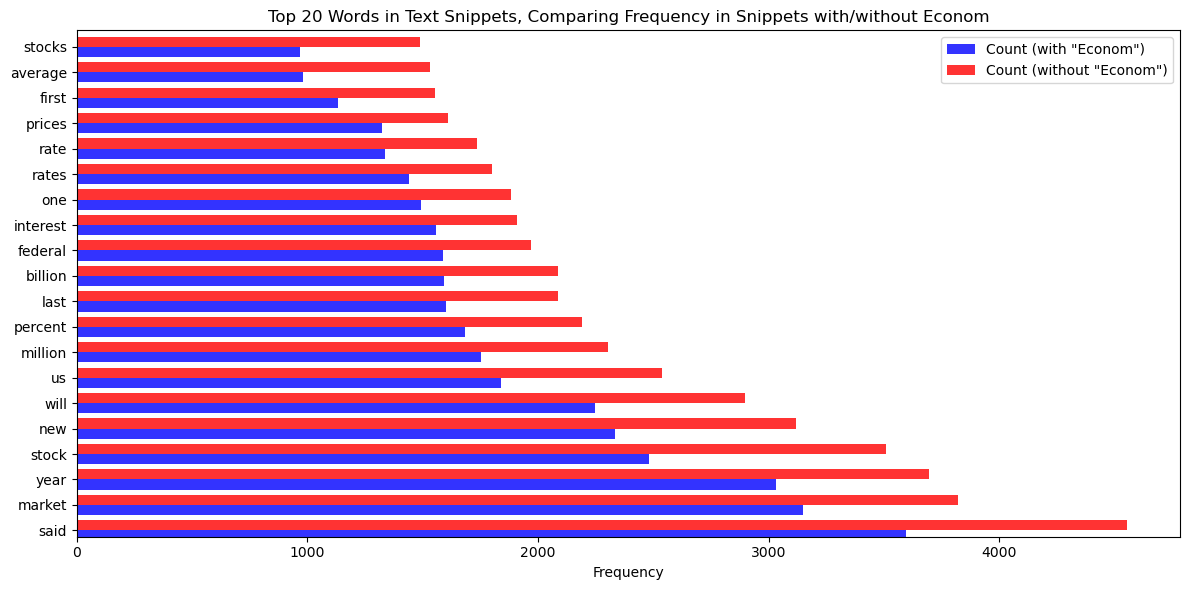

In [17]:
###############################
#
#         Question 3
#
###############################


from collections import Counter
import pandas as pd

# Load your data, adjust the file path or method based on your actual data
data = pd.read_csv('MLforEcon_W2024_pc6_data_without_response_v1.csv', header=None)

# Add a column 'text' to your DataFrame
data['text'] = data[0].apply(remove_html)
data['text'] = data['text'].apply(make_lowercase)
data['text'] = data['text'].apply(remove_stopwords)
data['text'] = data['text'].apply(remove_punctuations)

# Separate the text snippets into two groups: with and without "econom"
econom_snippets = data[data['text'].str.contains('econom', case=False)]
other_snippets = data[~data['text'].str.contains('econom', case=False)]

# Function to calculate word frequencies
def calculate_word_frequencies(text_list):
    word_counts = Counter()
    for text in text_list:
        words = text.split()
        word_counts.update(words)
    return word_counts

# Calculate word frequencies for snippets with "econom"
econom_word_freq = calculate_word_frequencies(econom_snippets['text'])

# Calculate word frequencies for snippets without "econom"
other_word_freq = calculate_word_frequencies(other_snippets['text'])

# Convert word frequencies to DataFrames for easier manipulation
econom_word_freq_df = pd.DataFrame.from_dict(econom_word_freq, orient='index', columns=['Count (with "Econom")'])
other_word_freq_df = pd.DataFrame.from_dict(other_word_freq, orient='index', columns=['Count (without "Econom")'])

# Sort the DataFrames by word frequency
econom_word_freq_df = econom_word_freq_df.sort_values(by='Count (with "Econom")', ascending=False)
other_word_freq_df = other_word_freq_df.sort_values(by='Count (without "Econom")', ascending=False)

# Plot the word frequencies for both groups on the same axes with non-overlapping bars
plt.figure(figsize=(12, 6))

# Define the width of each bar
bar_width = 0.4

# Plot bars for excerpts with "Econom"
econom_word_freq_df.head(20).plot(kind='barh', color='blue', ax=plt.gca(), alpha=0.8, position=1, width=bar_width, label='With "Econom"')

# Plot bars for excerpts without "Econom" shifted to the right
other_word_freq_df.head(20).plot(kind='barh', color='red', ax=plt.gca(), alpha=0.8, position=0, width=bar_width, label='Without "Econom"')

plt.title('Top 20 Words in Text Snippets, Comparing Frequency in Snippets with/without Econom')
plt.xlabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


TypeError: Axes.barh() got multiple values for argument 'height'

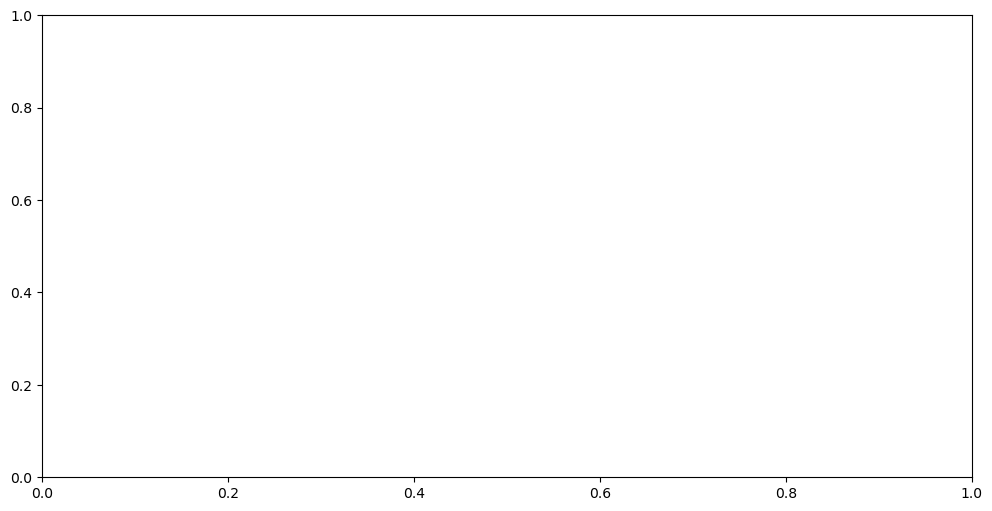

In [11]:
# Plot the word frequencies for both groups on the same axes with stacked bars and adjusted spacing
plt.figure(figsize=(12, 6))

# Combine the word frequencies DataFrames
combined_word_freq_df = pd.concat([econom_word_freq_df.head(20), other_word_freq_df.head(20)], axis=1)

# Plot stacked bars for both groups with adjusted spacing
combined_word_freq_df.plot(kind='barh', color=['blue', 'red'], ax=plt.gca(), alpha=0.7, height=0.8)

plt.title('Top 20 Words in Text Snippets')
plt.xlabel('Frequency')
plt.legend(['With "Econom"', 'Without "Econom"'])

plt.tight_layout()
plt.show()